In [1]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("salader/dogsvscats")

print("Path to dataset files:", path)

Using Colab cache for faster access to the 'dogsvscats' dataset.
Path to dataset files: /kaggle/input/dogsvscats


In [2]:
import tensorflow as tf
from tensorflow import keras
from keras import Sequential
from keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, BatchNormalization, Dropout
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [16]:
#generators (for loading the images data)
train_path = path + '/train'
train_ds = tf.keras.utils.image_dataset_from_directory(
    directory= train_path,
    labels="inferred",
    label_mode="int",  #cats=0, dogs=1
    batch_size=32,    # loads 32 images at a time
    image_size=(256, 256),  #reshaping all images to same size
    validation_split=0.3,  # 30% for validation
    subset="training",  # This is the training subset
    seed=42
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    directory=train_path,
    labels="inferred",
    label_mode="int",
    batch_size=32,
    image_size=(256, 256),
    validation_split=0.3,
    subset="validation",  # This is the validation subset
    seed=42  # Same seed as training!
)

test_path = path + '/test'
test_ds = tf.keras.utils.image_dataset_from_directory(
    directory= test_path,
    labels="inferred",
    label_mode="int",  #cats=0, dogs=1
    batch_size=32,    # loads 32 images at a time
    image_size=(256, 256)  #reshaping all images to same size
)
class_names = test_ds.class_names


Found 20000 files belonging to 2 classes.
Using 14000 files for training.
Found 20000 files belonging to 2 classes.
Using 6000 files for validation.
Found 5000 files belonging to 2 classes.


In [4]:
# Data augmentation function
def augment(image, label):
    image = tf.cast(image / 255.0, tf.float32)
    # Horizontal flip
    image = tf.image.random_flip_left_right(image)
    # Zoom effect (crop and resize)
    image = tf.image.resize(image, [256, 256])
    # Brightness and contrast
    image = tf.image.random_brightness(image, 0.2)
    image = tf.image.random_contrast(image, 0.8, 1.2)
    image = tf.image.random_saturation(image, 0.8, 1.2)
    return image, label

In [5]:
# Normalization
# These images are stored as numpy array which ranges (0-255), so we need to normalize it to (0-1) range
def process(image, label):
  image = tf.cast(image/255, tf.float32)
  return image, label

#mapping each image to its label
# num_parallel_calls=tf.data.AUTOTUNE -->parallelization (processes multiple images at once)
train_ds_processed = train_ds.map(augment, num_parallel_calls=tf.data.AUTOTUNE)
val_ds_processed = val_ds.map(process, num_parallel_calls=tf.data.AUTOTUNE)
test_ds_processed = test_ds.map(process, num_parallel_calls=tf.data.AUTOTUNE)

In [6]:
# Performance optimization
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.prefetch(buffer_size=AUTOTUNE)
# Clear memory before training
import gc
gc.collect()
tf.keras.backend.clear_session()

In [7]:
# creating CNN model
model = Sequential()

model.add(Conv2D(32, kernel_size=(3,3), padding='valid', activation='relu', input_shape=(256,256,3)))
model.add(BatchNormalization())  #reducing overfitting
model.add(MaxPooling2D(pool_size=(2,2), strides=2, padding='valid'))

model.add(Conv2D(64, kernel_size=(3,3), padding='valid', activation='relu', input_shape=(256,256,3)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2), strides=2, padding='valid'))

model.add(Conv2D(128, kernel_size=(3,3), padding='valid', activation='relu', input_shape=(256,256,3)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2), strides=2, padding='valid'))

model.add(Flatten())

model.add(Dense(128, activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(1, activation='sigmoid'))


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [8]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 254, 254, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 254, 254, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 127, 127, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 125, 125, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 125, 125, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 62, 62, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 60, 60, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 60, 60, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 30, 30, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 115200)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │    14,745,728 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,848,193 (56.64 MB)

 Trainable params: 14,847,745 (56.64 MB)

 Non-trainable params: 448 (1.75 KB)

In [9]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [10]:
# Callbacks
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True,
    verbose=1
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=3,
    min_lr=1e-7,
    verbose=1
)

In [11]:
history = model.fit(train_ds_processed, epochs=10, validation_data=val_ds_processed, callbacks=[early_stop, reduce_lr])

Epoch 1/10
438/438 ━━━━━━━━━━━━━━━━━━━━ 114s 232ms/step - accuracy: 0.5497 - loss: 3.3460 - val_accuracy: 0.5210 - val_loss: 0.9544 - learning_rate: 0.0010
Epoch 2/10
438/438 ━━━━━━━━━━━━━━━━━━━━ 64s 147ms/step - accuracy: 0.6096 - loss: 0.6604 - val_accuracy: 0.6642 - val_loss: 0.6321 - learning_rate: 0.0010
Epoch 3/10
438/438 ━━━━━━━━━━━━━━━━━━━━ 68s 154ms/step - accuracy: 0.6808 - loss: 0.6057 - val_accuracy: 0.6545 - val_loss: 0.8663 - learning_rate: 0.0010
Epoch 4/10
438/438 ━━━━━━━━━━━━━━━━━━━━ 65s 148ms/step - accuracy: 0.6881 - loss: 0.6191 - val_accuracy: 0.6832 - val_loss: 0.5994 - learning_rate: 0.0010
Epoch 5/10
438/438 ━━━━━━━━━━━━━━━━━━━━ 64s 145ms/step - accuracy: 0.7144 - loss: 0.5706 - val_accuracy: 0.7243 - val_loss: 0.5500 - learning_rate: 0.0010
Epoch 6/10
438/438 ━━━━━━━━━━━━━━━━━━━━ 64s 147ms/step - accuracy: 0.7464 - loss: 0.5353 - val_accuracy: 0.6918 - val_loss: 0.5838 - learning_rate: 0.0010
Epoch 7/10
438/438 ━━━━━━━━━━━━━━━━━━━━ 67s 153ms/step - accuracy: 0.

- **batches=625, batch_size=32** -->**625*32=20000 images**
- **batches 438 , batch_size=32 --> images= 438*32 =14000**

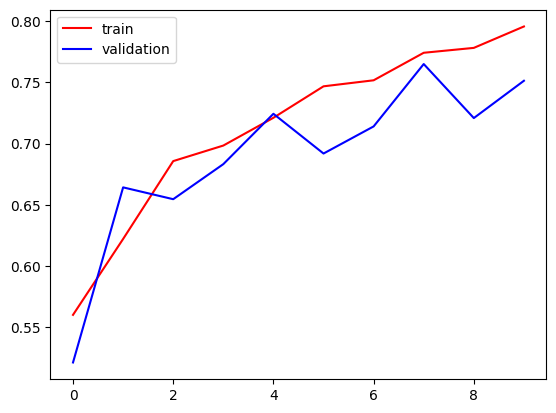

In [12]:
import matplotlib.pyplot as plt
plt.plot(history.history['accuracy'], color='red', label='train')
plt.plot(history.history['val_accuracy'], color='blue', label='validation')
plt.legend()
plt.show()


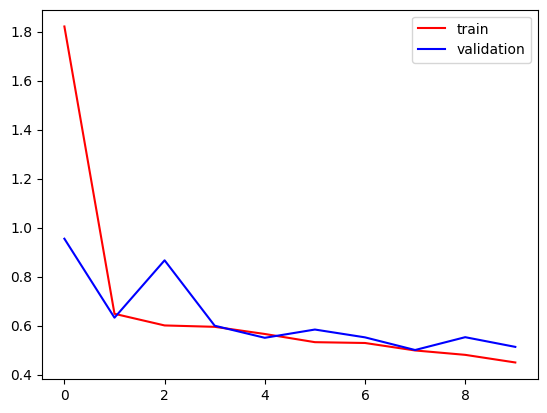

In [13]:
plt.plot(history.history['loss'], color='red', label='train')
plt.plot(history.history['val_loss'], color='blue', label='validation')
plt.legend()
plt.show()

### We clearly saw earlier that there was overfitting. Ways we implemented to reduce overfitting:
- Data Augmentation
- Dropout
- Batch norm


In [14]:
# Evaluate on test set
test_loss, test_acc = model.evaluate(test_ds_processed)
print(f" Test Accuracy: {test_acc:.4f}")
print(f" Test Loss: {test_loss:.4f}")

157/157 ━━━━━━━━━━━━━━━━━━━━ 17s 108ms/step - accuracy: 0.7712 - loss: 0.4946
 Test Accuracy: 0.7680
 Test Loss: 0.5011


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 532ms/step


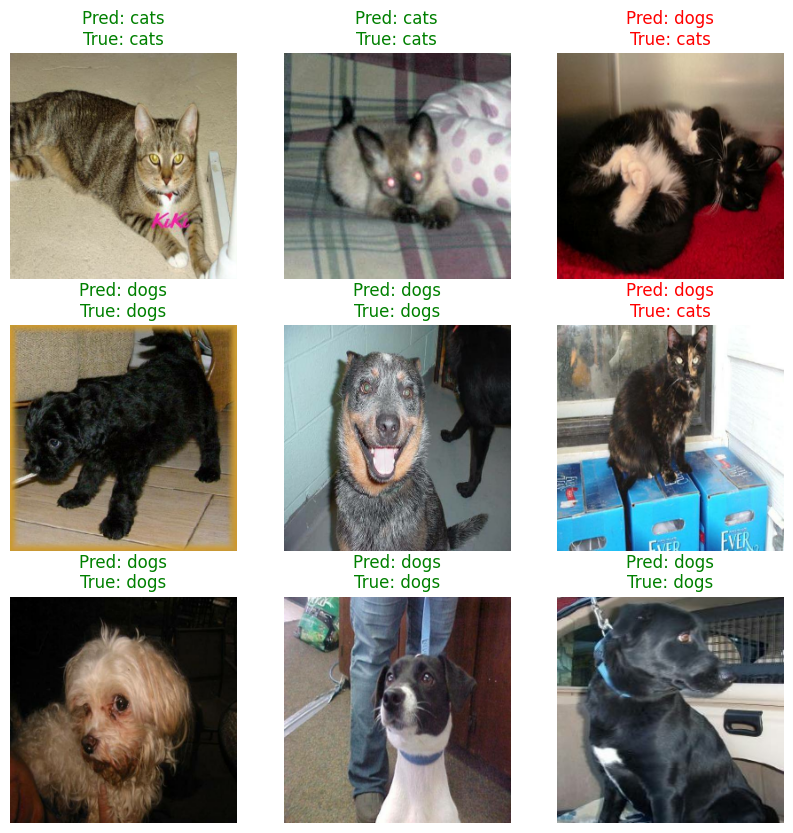

In [17]:
import numpy as np

# Take some test images and predict
for images, labels in test_ds.take(1):
    preds = model.predict(images)
    preds = (preds > 0.5).astype("int32")

    plt.figure(figsize=(10,10))
    for i in range(9):
        ax = plt.subplot(3,3,i+1)
        plt.imshow(images[i].numpy().astype("uint8"))
        true_label = class_names[labels[i]]
        pred_label = class_names[preds[i][0]]
        color = "green" if true_label == pred_label else "red"
        plt.title(f"Pred: {pred_label}\nTrue: {true_label}", color=color)
        plt.axis("off")
